# Notebook to format data from "Behavioural inference from signal processing using animal-borne multi-sensor loggers: a novel solution to extend the knowledge of sea turtle ecology", Jeantet et al (2020).

Data can be found [here](https://datadryad.org/stash/dataset/doi:10.5061/dryad.hhmgqnkd9).

[Supplementary material](https://rs.figshare.com/articles/journal_contribution/Supplementary_Tables_and_Figure_from_Behavioural_inference_from_signal_processing_using_animal-borne_multi-sensor_loggers_a_novel_solution_to_extend_the_knowledge_of_sea_turtle_ecology/12279848?backTo=/collections/Supplementary_material_from_Behavioural_inference_from_signal_processing_using_animal-borne_multi-sensor_loggers_a_novel_solution_to_extend_the_knowledge_of_sea_turtle_ecology_/4971233)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/jeantet_turtles'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/jeantet_turtles'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
features_fps = glob.glob(raw_data_dir + '/*.h5')
annotations_fps = glob.glob(raw_data_dir + '/*.csv')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Dataset metadata
dataset_metadata = {}
sr = 20
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'jeantet_turtles'

In [6]:
## Integer codes for individuals

clip_id_to_individual_id = {'CC-07-107_11-02-2019' : 0,
 'CC-07-108_11-02-2019' : 1,
 'CC-07-115_13-05-2019' : 2,
 'CC-07-115_14-05-2019' : 3,
 'CC-07-47_14-02-2018' : 4,
 'CC-07-48_04-10-2018' : 5,
 'CC-07-48_06-10-2018' : 6,
 'CC-07-48_08-04-2019_1' : 7,
 'CC-07-48_08-04-2019_2' : 7,
 'CC-07-48_08-04-2019_3' : 7,
 'CC-07-48_08-10-2018' : 8,
 'CC-07-48_10-10-2018' : 9,
 'CC-07-48_18-02-2019' : 10,
 'CC-07-48_22-05-2018' : 11,
 'CC-07-48_26-05-2018' : 12,
 'CC-07-59_20-05-2018' : 13}

dataset_metadata['individual_ids'] = [i for i in range(14)] # There are 14 individuals but only 13 mentioned in the paper
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

individuals = sorted({clip_id_to_individual_id[key] for key in clip_id_to_individual_id})

In [7]:
# Set up data splits by individual

test_proportion = .25
val_proportion = .2
num_individuals = len(individuals)

test_num_individuals = int(test_proportion * num_individuals)
val_num_individuals = int(val_proportion * num_individuals)

rng = np.random.default_rng(608)
test_individuals = list(rng.choice(individuals, size = test_num_individuals, replace = False))
test_individuals.sort()

dev_individuals = individuals.copy()
for i in test_individuals:
    dev_individuals.remove(i)
    
val_individuals = list(rng.choice(dev_individuals, size = val_num_individuals, replace = False))
val_individuals.sort()
    
train_individuals = dev_individuals.copy()
for i in val_individuals:
    train_individuals.remove(i)
    
print(train_individuals)
print(val_individuals)
print(dev_individuals)
print(test_individuals)

[0, 1, 5, 7, 8, 9, 10, 11, 12]
[2, 13]
[0, 1, 2, 5, 7, 8, 9, 10, 11, 12, 13]
[3, 4, 6]


In [8]:
# Set up clip ids 

# Clip ids
clip_ids = []
test_clip_ids = []
train_clip_ids = []
val_clip_ids = []
dev_clip_ids = []
for fp in features_fps:
    fn = fp.split('/')[-1]
    clip_id = fn.split('.')[0]
    individual = clip_id_to_individual_id[clip_id]
    clip_ids.append(clip_id)
    if individual in train_individuals:
        train_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in val_individuals:
        val_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in test_individuals:
        test_clip_ids.append(clip_id)
    
train_clip_ids.sort()
val_clip_ids.sort()
dev_clip_ids.sort()
test_clip_ids.sort()
    
dataset_metadata['clip_ids'] = clip_ids
dataset_metadata['train_clip_ids'] = train_clip_ids
dataset_metadata['test_clip_ids'] = test_clip_ids
dataset_metadata['val_clip_ids'] = val_clip_ids
dataset_metadata['dev_clip_ids'] = dev_clip_ids

In [9]:
# Check that each clip has a corresponding annotation file
for clip_id in clip_ids:
    if not os.path.join(raw_data_dir, 'Behaviors_' + clip_id +'.csv') in annotations_fps:
        print('clip id %s does not have corresponding annotations' % clip_id)
        
print("Checked that all clips have corresponding annotations")

Checked that all clips have corresponding annotations


## Create dataset-level metadata

In [10]:
## Integer codes for specific behaviors

# list of behaviors (from Jeantet et al 2020)
beh_names = ['unknown', 
            'breathing', 
            'feeding', 
            'gliding', 
            'resting', 
            'scratching', 
            'staying_at_surface', 
            'swimming']

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

# extract directly from the annotations
fp = annotations_fps[0]
all_annotations = pd.read_csv(fp, delimiter = ';')

for fp in annotations_fps[1:]:
    all_annotations = all_annotations.append(pd.read_csv(fp, delimiter = ';'))

In [11]:
# What are the observed labels?

all_annotations['Behavior'].value_counts()

Swimming ascent               774
Swimming descent              773
Swimming horizontally         601
Swimming on the bottom        536
Gliding ascent                497
Right U-turn                  470
Stay in surface               427
Resting                       408
Left U-turn                   403
Gliding descent               403
Breathing                     389
Grabbing stationary           350
Swimming 1 ascent             336
Chewing stationary            303
Resting in flow               271
Swimming 1 horizontally       268
Swimming 1 descent            235
Shaking                       146
Foraging                      145
Prospection                   130
Chewing on movement           127
Grabbing on movement          121
Scratching                    117
Shaking head                   98
Resting watching               89
Obstacle                       53
Watching                       48
Scratching head                47
Sand                           46
Flipper beat  

In [12]:
# Map to beh_labels following supplementary material

observed_labels_to_beh_label = {'Swimming ascent' : 'swimming',
                                'Swimming descent' : 'swimming',
                                'Swimming horizontally' : 'swimming',
                                'Swimming on the bottom' : 'swimming',
                                'Gliding ascent' : 'gliding',
                                'Right U-turn' : 'swimming',
                                'Stay in surface' : 'staying_at_surface',
                                'Resting' : 'resting',
                                'Left U-turn' : 'swimming',
                                'Gliding descent' : 'gliding',
                                'Breathing' : 'breathing',
                                'Grabbing stationary' : 'feeding',
                                'Swimming 1 ascent' : 'swimming',
                                'Chewing stationary' : 'feeding',
                                'Resting in flow' : 'resting',
                                'Swimming 1 horizontally' : 'swimming',
                                'Swimming 1 descent' : 'swimming',
                                'Shaking' : 'unknown',
                                'Foraging' : 'unknown',
                                'Prospection' : 'swimming',
                                'Chewing on movement' : 'feeding',
                                'Grabbing on movement' : 'feeding',
                                'Scratching' : 'scratching',
                                'Shaking head' : 'unknown',
                                'Resting watching' : 'resting',
                                'Obstacle' : 'unknown',
                                'Watching' : 'unknown',
                                'Scratching head' : 'scratching',
                                'Sand' : 'unknown',
                                'Flipper beat' : 'unknown',
                                'Interaction' : 'unknown',
                                'Swimming fast descent' : 'swimming',
                                'Catching' : 'feeding',
                                'Landing' : 'unknown',
                                'Resting active' : 'resting',
                                'New video' : 'unknown',
                                'Swimming fast ascent' : 'swimming',
                                'Escape' : 'unknown',
                                'Scratching camera' : 'scratching',
                                'Catching jellyfish' : 'feeding', 
                                'Swimming in place' : 'swimming',
                                'Swimming fast horizontally' : 'swimming',
                                'Pursuit' : 'unknown',
                                'Grabbing the wall' : 'feeding', 
                                'Stepping back' : 'swimming',
                                'Time mark' : 'unknown',
                                'Regurgitating' : 'unknown',
                                'Chewing jellyfish' : 'feeding',
                                'Hunting jellyfish' : 'unknown'
                               }

In [13]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'StaticAccX', 'StaticAccY', 'StaticAccZ', 'GyrX', 'GyrY', 'GyrZ', 'Depth', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [14]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

In [15]:
# How much time is represented?

length = 0
for clip_id in clip_ids:
    # load features
    features_fp = os.path.join(raw_data_dir, clip_id + '.h5')
    features_hf = h5py.File(features_fp, 'r')
    features = np.array(features_hf.get('data'))
    length += np.shape(features)[0]
total_dur_sec = length / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

total duration is 277597.150000 seconds, i.e. 77.110319 hours


## Format Clip Data

In [16]:
# use butterworth filter to extract low and high frequency components
def extract_static(series, low_cutoff_freq):
    # extract static component
    sos = signal.butter(10, low_cutoff_freq, 'low', fs=sr, output='sos')
    low_passed_series = signal.sosfilt(sos, series)
    remaining_series = series - low_passed_series
    return low_passed_series, remaining_series

In [17]:
# For each clip, create and save the data in the correct format

for clip_id in clip_ids:
    # load features
    features_fp = os.path.join(raw_data_dir, clip_id + '.h5')
    features_hf = h5py.File(features_fp, 'r')
    features = np.array(features_hf.get('data'))
    static_components = np.zeros((np.shape(features)[0], 3))
    clip_dur_samples = np.shape(features)[0]
    
    # correct for gravity
    for i in range(3): #first 3 channels are acceleration
        to_correct = features[:, i]
        static, corrected = extract_static(to_correct, 0.3)
        features[:, i] = corrected
        static_components[:, i] = static
        
    # should we correct for sensor placement?
    # for now, no. they do this correction in the article, but it seems very sensitive to hand-chosen reference
    # and similar articles do not correct for sensor placement        
    
    # load annotations
    annotations_fp = os.path.join(raw_data_dir, 'Behaviors_' + clip_id + '.csv')
    annotations_df = pd.read_csv(annotations_fp, delimiter = ';')
    annotations_df = annotations_df[['Behavior', 'Start (s)', 'Stop (s)']]
    
    # reformat annotations
    per_frame_annotations = np.zeros([clip_dur_samples, 1]) # populate with 0's, aka "unkown"
    for i, row in annotations_df.iterrows():
        beh_label = observed_labels_to_beh_label[row['Behavior']]
        int_label = beh_str_to_int[beh_label]
        start_sec = row['Start (s)']
        end_sec = row['Stop (s)']
        start_sample = int(start_sec * sr)
        end_sample = int(end_sec * sr)
        per_frame_annotations[start_sample: end_sample, :] = int_label
        
    # insert individual id
    individual_id = clip_id_to_individual_id[clip_id]
    per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)
    
    depth = features[:, -1]
    depth = np.gradient(depth)
    depth = np.expand_dims(depth, axis = 1)
    
    clip_data = np.concatenate([features[:, :3], static_components, features[:, 3:6], depth, per_frame_individual_id, per_frame_annotations], axis = 1)
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    #
    #np.save(clip_data_fp, clip_data)
    np.savetxt(clip_data_fp, clip_data, delimiter=",")
    

## Check it all looks ok

In [18]:
clip_id = clip_ids[4]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')

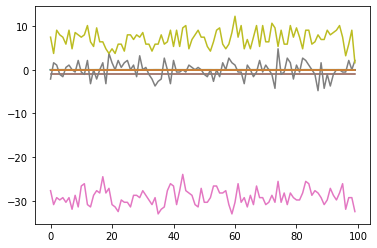

In [19]:
for i in range(np.shape(data)[1]):
    plt.plot(data[1000:1100, i])

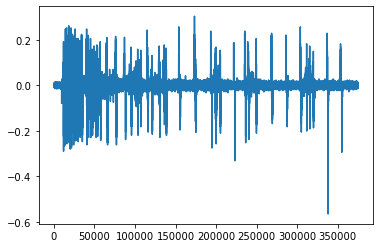

In [20]:
plt.plot(data[:, 9])

## Plot Dataset Summary

In [21]:
# Count class representation

beh_names = dataset_metadata['label_names']
train_label_count = {name : 0 for name in beh_names}
val_label_count = {name : 0 for name in beh_names}
dev_label_count = {name : 0 for name in beh_names}
test_label_count = {name : 0 for name in beh_names}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        if clip_id in dataset_metadata['train_clip_ids']:
            train_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['val_clip_ids']:
            val_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['test_clip_ids']:
            test_label_count[name] += counts[key]

train_label_perc = {name : 0 for name in beh_names}
val_label_perc = {name : 0 for name in beh_names}
dev_label_perc = {name : 0 for name in beh_names}
test_label_perc = {name : 0 for name in beh_names}

for name in beh_names[1:]:
    train_label_perc[name] = train_label_count[name] / sum([train_label_count[j] for j in beh_names[1:]])
    val_label_perc[name] = val_label_count[name] / sum([val_label_count[j] for j in beh_names[1:]])
    dev_label_perc[name] = dev_label_count[name] / sum([dev_label_count[j] for j in beh_names[1:]])
    test_label_perc[name] = test_label_count[name] / sum([test_label_count[j] for j in beh_names[1:]])

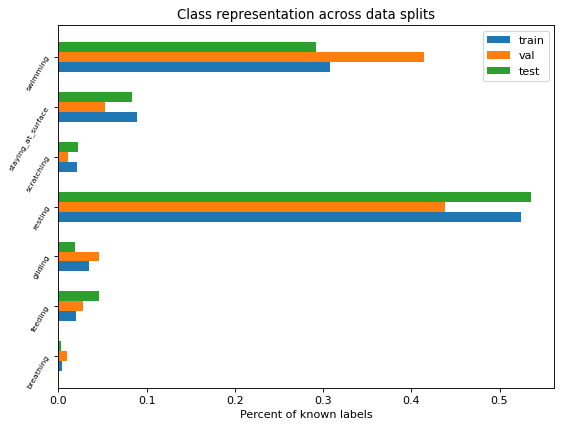

In [22]:
# Plot class representation

keys = np.arange(len(beh_names))[1:]
offset = 0.2
width = 0.2
plt.figure(figsize=(8, 6), dpi=80)

plt.barh(keys - offset, [train_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'train')
plt.barh(keys, [val_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'val')
plt.barh(keys + offset, [test_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'test')
plt.title("Class representation across data splits")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.png')

plt.savefig(target_fp)
plt.show()

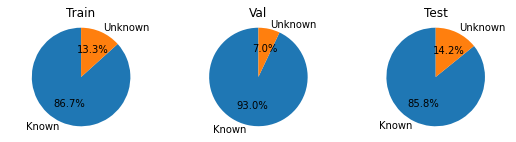

In [23]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,3, figsize = (9,2))
plt.title("blah")

ax[0].pie(train_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Train')

ax[1].pie(val_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Val')

ax[2].pie(test_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[2].set_title('Test')

target_fp = os.path.join(formatted_data_dir, 'perc_known.png')

plt.savefig(target_fp)

plt.show()
